In [3]:
from sklearn import decomposition
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
# Loading data into numpy arrays
inp_paras = np.load('data/inp_paras_995.npy')
aoas_opt = np.load('data/aoas_opt_995.npy')
airfoils_opt = np.load('data/airfoils_opt_995.npy')

print(airfoils_opt.reshape(995,-1).shape)
print(inp_paras.shape)
print(aoas_opt.shape)

(995, 384)
(995, 3)
(995,)


Number of latent dimensions to explain 99% of variance:  5


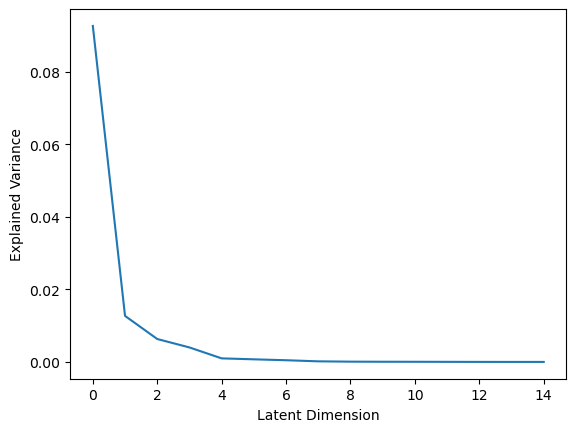

In [5]:
# Centering the airfoils
airfoils_opt[:, :, 0] -= airfoils_opt[:, :, 0].mean()
airfoils_opt[:, :,1] -= airfoils_opt[:,:,1].mean()

# PCA for dimesniosn reduction of airfoil geometries
airfoils_opt_new = airfoils_opt.reshape(995,-1) # FLatten the 3D array to 2D for the PCA estimator
estimator = decomposition.PCA(n_components=15)
estimator.fit(airfoils_opt_new) 
components_ = estimator.components_

# Scree Plot
# Plotting the explained variance for each latent dimension
plt.plot(estimator.explained_variance_)
plt.ylabel("Explained Variance")
plt.xlabel("Latent Dimension")

cumulative_explained_var_ratio = np.cumsum(estimator.explained_variance_ratio_)
num_dims_to99 = np.argmax(cumulative_explained_var_ratio > .99) # Number of dimesnions needed to explain 99% of variance
print("Number of latent dimensions to explain 99% of variance: ", num_dims_to99)

In [6]:
# Transforming airfoil geometry data into a lower dimesnion space
lowDProjection = np.zeros((995, 384))

pca = PCA(n_components=num_dims_to99)
pca.fit(airfoils_opt_new)
lowDProjection_airfoils_opt = pca.transform(airfoils_opt_new)
print(lowDProjection_airfoils_opt.shape)

# Example of recasting our data back into the orginal dimension space
reconstruct_data = pca.inverse_transform(lowDProjection_airfoils_opt)
print(reconstruct_data.shape)

(995, 5)
(995, 384)


In [7]:
# Splitting data into training and testing
n = 0.8
size_train = int(n*lowDProjection_airfoils_opt.shape[0])

x_train = inp_paras[:size_train]
y_train = lowDProjection_airfoils_opt[:size_train]

x_test = inp_paras[size_train:]
y_test = lowDProjection_airfoils_opt[size_train]

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


(796, 3)
(199, 3)
(796, 5)


In [ ]:
# DNN Building
class Airfoil_NN(nn.Module):
    def __init__(self, output_param, input_param = 3, neurons_per_layer = [3, 3]):
        super().__init__() 
        self.input_param = input_param
        self.output_param = output_param
        self.neurons_per_layer = neurons_per_layer

        self.hidden1 = nn.Linear(self.input_param, self.neurons_per_layer[0])
        self.act1 = nn.Softplus()
        self.hidden2 = nn.Linear(self.neurons_per_layer[0], self.neurons_per_layer[1])
        self.act2 = nn.ReLU()
        self.output = nn.Linear(self.neurons_per_layer[1], self.output_param)
        self.act_output = nn.ReLU()


    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act_output(self.output(x))
        return x 

# Linear --> Softplus --> Linear --> ReLU --> Linear --> ReLU 
model = Airfoil_NN(5, 3, [8, 16]) # [output layer neurons, input layer neurons, hiddern layer 1, hidden layer 2]

# train the model
loss_fn   = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100
batch_size = 80 # Higher batch sizes tend to give us lower losses

# Batch Fed Training Loop
for epoch in range(n_epochs):
    for i in range(0, len(x_train), batch_size):
        Xbatch = x_train[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y_train[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Performance Monitoring 
    if(epoch % 20 == 0):
        print(f"Epoch {epoch}, Loss: {loss}")
        

Epoch 0, Loss: 25622441099264.0
Epoch 20, Loss: 3675921920.0
Epoch 40, Loss: 8.530415534973145
Epoch 60, Loss: 0.9766276478767395
Epoch 80, Loss: 0.5702274441719055
